<a href="https://colab.research.google.com/github/KhoaNguyenM/AI-powered-Facial-Recognition-Attendance-System/blob/main/BT4_FaceRegcot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GHOSTFACENETS MODEL

#  1.Import thư viện

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip uninstall tensorflow -y > /dev/null 2>&1
!pip install tensorflow==2.12.0 > /dev/null 2>&1
!pip install faiss-gpu > /dev/null 2>&1

In [ ]:
import faiss
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

In [ ]:
!unzip -qq /content/drive/MyDrive/BT4_CV/Code_EXAM/data_new.zip

replace data_new/images/173_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# 2.Đọc và load vector embedding

In [ ]:
aa = np.load("/content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/root_embs/vn2db.npz")
embs, imm_classes, filename = aa["embs"], aa["imm_classes"], aa["filenames"]
emb, img_class = embs.astype("float32"), imm_classes.astype("int")
# embs: 4720 vector embedding, img_class : 4720 label, filename : filename của 4720 ảnh
print(emb.shape)
dimensions = 512 #FaceNet output is 128 dimensional vector

metric = 'cosine' #euclidean, cosine

if metric == 'euclidean':
    index = faiss.IndexFlatL2(dimensions)
elif metric == 'cosine':
    index = faiss.IndexFlatIP(dimensions)
    # faiss.normalize_L2(emb)

(864, 512)


# 3.Crop face từ ảnh test.

In [ ]:
import tensorflow as tf
!pip install keras-cv-attention-models > /dev/null 2>&1
from keras_cv_attention_models import *

In [ ]:
!cp /content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/face_detector.py face_detector.py

In [ ]:
from face_detector import YoloV5FaceDetector
folder_raw_face = "/content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/test_cases"
data_path = YoloV5FaceDetector().detect_in_folder(folder_raw_face)

Detecting:  83%|████████▎ | 10/12 [00:17<00:05,  2.55s/it]

>>>> None face detected in image: /content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/test_cases/Tus_02.jpg


Detecting:  92%|█████████▏| 11/12 [00:21<00:03,  3.02s/it]

>>>> None face detected in image: /content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/test_cases/Tus_03.jpg


Detecting: 100%|██████████| 12/12 [00:22<00:00,  1.84s/it]

>>>> Saved aligned face images in: /content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/test_cases_aligned_112_112


In [ ]:
!cp -r /content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/test_cases_aligned_112_112 /content/

In [ ]:
!cp /content/drive/MyDrive/BT4_CV/Code_EXAM/data.csv /content/

# 4.Tạo Face Embedding

In [ ]:
class Eval_image:
    def __init__(self, model_interf, img_path, output_dir,root_img_path):

        if isinstance(model_interf, str) and model_interf.endswith("h5"):
            model = tf.keras.models.load_model(model_interf)
            self.model_interf = lambda imms: model((imms - 127.5) * 0.0078125).numpy()
        else:
            self.model_interf = model_interf
        self.dist_func = lambda aa, bb: np.dot(aa, bb) # hàm tính khoảng cách giữa 2 vector
        self.output_dir = output_dir
        self.img_path = img_path
        print('begin serving')
        self.root_path = root_img_path
        self.embs, self.imm_classes, self.filenames = self.prepare_image_and_embedding(self.img_path, self.output_dir)

    def prepare_image_and_embedding(self, img_folder, output_dir):
        save_embeddings = output_dir
        # kiểm tra đường dẫn, nếu đã lưu các embedding vector vào file npz thì chỉ load lại
        if save_embeddings and os.path.exists(save_embeddings):
            print(">>>> Reloading from backup:", save_embeddings)
            aa = np.load(save_embeddings)
            embs, imm_classes, names = aa["embs"], aa["imm_classes"], aa["filenames"]
            embs, img_classes = embs.astype("float32"), imm_classes.astype("int")
        else:
            # chưa lưu => đọc mỗi hình
            img_shape = (112, 112)
            imgs = pd.read_csv('./data.csv')['image'].tolist() # danh sách tên các hình
            labels = pd.read_csv('./data.csv')['label'].tolist() # danh sách label của các hình
            embs = [] # list of embeddings
            img_classes = [] # list nhãn của mỗi hình (mỗi vector embedding)
            names = [] # list lưu tên file của mỗi hình
            for i,img_path in enumerate(tqdm(imgs)):
                img_path = os.path.join(self.root_path,img_path) # đọc file từng ảnh
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_shape, interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = np.expand_dims(img, axis=0) # biến ảnh về kích thước (1,112,112,3)

                emb = self.model_interf(img) # lưu vector embedding
                emb = normalize(np.array(emb).astype("float32"))[0] # chuẩn hoá 1 vector theo L2 norm
                img_class = int(labels[i]) # nhãn của ảnh hiện tại
                img_classes.append(img_class) # lưu nhãn của ảnh hiện tại
                embs.append(emb) # lưu vector embedding của ảnh hiện tại
                filename = os.path.basename(img_path) # lấy filename (dạng abc.xyz)
                names.append(filename) # lưu filename của ảnh hiện tại
            # lưu tất cả thông tin trên vào 1 file npy
            np.savez(output_dir, embs=embs, imm_classes=img_classes, filenames=names)
            print("file chứa 4720 vector được save tại")
        return np.array(embs),np.array(img_classes),np.array(names)


    def do_evaluation(self):
        register_ids = np.unique(self.imm_classes) ## đếm xem có bao nhiêu identity trong dataset aka có bao nhiêu người có mặt trong dataset :D
        print(">>>> [base info] embs:", self.embs.shape, "imm_classes:", self.imm_classes.shape, "register_ids:", register_ids.shape)

        register_base_embs = np.array([]).reshape(0, self.embs.shape[-1]) # lưu vector đại diện của từng identity
        register_base_dists = []
        for register_id in tqdm(register_ids, "Evaluating"):
            # với từng identity: tìm các hình chứa gương mặt của người đó
            pos_pick_cond = self.imm_classes == register_id
            # lấy vector của các gương mặt đó
            pos_embs = self.embs[pos_pick_cond]
            # tạo ra vector đại diện cho identity đó : sum các vector gương mặt, sau đó normalize
            register_base_emb = normalize([np.sum(pos_embs, 0)])[0]
            # tính similarity của vector đại diện tới toàn bộ vector trong dataset
            register_base_dist = self.dist_func(self.embs, register_base_emb)
            register_base_dists.append(register_base_dist) # lưu kết quả vào 1 list
            register_base_embs = np.vstack([register_base_embs, register_base_emb])
        # save 1000 vector đại diện
        new_path = self.output_dir.replace(os.path.basename(self.output_dir),"processed_1000embedding.npz")
        print("saving vector đại diện tại: ",new_path)
        np.savez(new_path,embs =register_base_embs)
        register_base_dists = np.array(register_base_dists).T # similarity (cosine similarity) của toàn bộ identity tới toàn bộ vector trong dataset
        # cosine similarity from one image to each class
        print(register_base_dists.shape) # như vậy nó có shape 4720x1000

        # đồng thời theo chiều ngược lại : 1 ảnh (trong 4720 ảnh trong dataset), sẽ dc tính độ tương tự với 1000 vector đại diện
        ### bắt đầu quá trình tính toán accuracy

        # register_base_dists.argmax(1) => tìm identity tương tự nhất cho mỗi ảnh
        # accuracy = số lượng ảnh mà model detect identity đúng / số lượng ảnh (4720)
        accuracy = (register_base_dists.argmax(1) == self.imm_classes).sum() / register_base_dists.shape[0]
        print("register_ids shape: ",register_ids.shape)
        print("self.imm_classes shape: ",self.imm_classes.shape)

        # tạo 1 array có 4720 dòng x 1000 cột => mỗi dòng là 1 hình, hình dc predict có identity nào thì giá trị cột đó =1
        reg_pos_cond = np.equal(register_ids, np.expand_dims(self.imm_classes, 1))
        print(reg_pos_cond.shape) # array co 1 nghin cot, gia tri tai cot label =1

        # tính similarity của hình đó với vector identity gần nhất (positive prediction)
        reg_pos_dists = register_base_dists[reg_pos_cond].ravel()
        print(reg_pos_dists.shape) # 4720
        # similarity của các hình với các 999 vector identity xa hơn (999 negative prediction)
        reg_neg_dists = register_base_dists[np.logical_not(reg_pos_cond)].ravel()
        print(reg_neg_dists.shape) # 4720*999
        # turn it into a binary classification
        # label: tất cả prediction của model (positive hay negative) đều dc flatten
        # score: similarity tương ứng của model cho các quyết định đó
        label = np.concatenate([np.ones_like(reg_pos_dists), np.zeros_like(reg_neg_dists)])
        score = np.concatenate([reg_pos_dists, reg_neg_dists]) #distance tai cot co label va k co label
        return accuracy,score,label

def plot_tpr_far(score, label, new_figure=True, label_prefix=""):
    fpr, tpr, _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)

    fpr_show = [10 ** (-ii) for ii in range(1, 7)[::-1]]
    fpr_reverse, tpr_reverse = fpr[::-1], tpr[::-1]
    tpr_show = [tpr_reverse[np.argmin(abs(fpr_reverse - ii))] for ii in fpr_show]
    print(pd.DataFrame({"FPR": fpr_show, "TPR": tpr_show}).set_index("FPR").T.to_markdown())

    try:
        import matplotlib.pyplot as plt

        fig = plt.figure() if new_figure else None
        label = "AUC = %0.4f%%" % (roc_auc * 100)
        if label_prefix and len(label_prefix) > 0:
            label = label_prefix + " " + label
        plt.plot(fpr, tpr, lw=1, label=label)
        plt.xlim([10 ** -6, 0.1])
        plt.xscale("log")
        plt.xticks(fpr_show)
        plt.xlabel("False Positive Rate")
        plt.ylim([0, 1.0])
        plt.yticks(np.linspace(0, 1.0, 8, endpoint=True))
        plt.ylabel("True Positive Rate")

        plt.grid(linestyle="--", linewidth=1)
        plt.title("ROC")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    except:
        print("matplotlib plot failed")
        fig = None
    return fig

In [ ]:
demo_image = Eval_image("/content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/GhostFaceNet_W1.3_S1_ArcFace.h5", "./data_new/images", output_dir="/content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/root_embs/vn2db.npz",root_img_path="/content/data_new/images")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


begin serving
>>>> Reloading from backup: /content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/root_embs/vn2db.npz


# 5.Chạy và đánh giá model với tập train

>>>> [base info] embs: (864, 512) imm_classes: (864,) register_ids: (199,)


Evaluating: 100%|██████████| 199/199 [00:00<00:00, 206.32it/s]


saving vector đại diện tại:  /content/drive/MyDrive/BT4_CV/Code_EXAM/Model_Ghost/root_embs/processed_1000embedding.npz
(864, 199)
register_ids shape:  (199,)
self.imm_classes shape:  (864,)
(864, 199)
(864,)
(171072,)
|     |    1e-06 |    1e-05 |   0.0001 |    0.001 |     0.01 |      0.1 |
|:----|---------:|---------:|---------:|---------:|---------:|---------:|
| TPR | 0.967593 | 0.974537 | 0.989583 | 0.996528 | 0.997685 | 0.998843 |


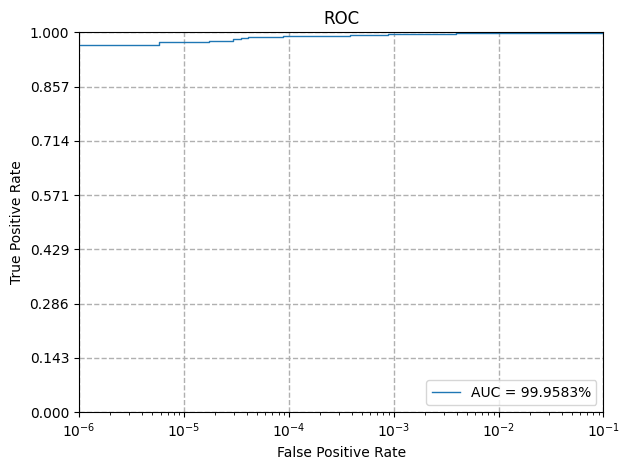

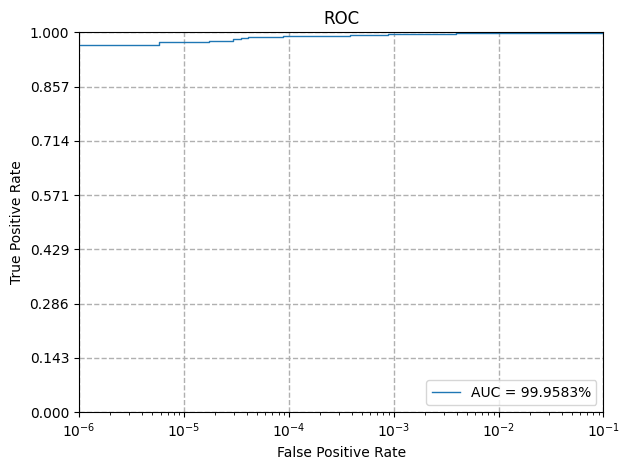

In [ ]:
acc,scores,labels = demo_image.do_evaluation()
plot_tpr_far(scores, labels)

# 6.Tạo vector đại diện cho identity

In [ ]:
register_ids = np.unique(demo_image.imm_classes) ## đếm xem có bao nhiêu identity trong dataset aka có bao nhiêu người có mặt trong dataset :D
print(">>>> [base info] embs:", demo_image.embs.shape, "imm_classes:", demo_image.imm_classes.shape, "register_ids:", register_ids.shape)

register_base_embs = np.array([]).reshape(0, demo_image.embs.shape[-1]) # lưu vector đại diện của từng gương mặt
mean_embss = []
for register_id in tqdm(register_ids, "Evaluating"):
    # với từng identity: tìm các hình chứa gương mặt của người đó
    pos_pick_cond = demo_image.imm_classes == register_id
    # lấy vector của các gương mặt đó
    pos_embs = demo_image.embs[pos_pick_cond]
    # tạo ra vector đại diện cho identity đó : sum các vector gương mặt, sau đó normalize
    register_base_emb = normalize([np.sum(pos_embs, 0)])[0]
    mean_embss.append(register_base_emb)
mean_embss = np.array(mean_embss)

>>>> [base info] embs: (864, 512) imm_classes: (864,) register_ids: (199,)


Evaluating: 100%|██████████| 199/199 [00:00<00:00, 1580.39it/s]


In [ ]:
# Identity hiện tại bắt đầu từ 199
current_identity = 199

# 6.Thêm nhãn mới và label mới

Tạo hàm add thêm vector vào danh sách vector hiện tại

Hàm kết hợp giữa add vector embedding và cập nhật file name, identity

In [ ]:
class UpdateIdentityInfo:
    def __init__(self, mean_embss, model_interface, imm_classes, filename, current_identity):
        self.mean_embss = mean_embss
        self.model_interface = model_interface
        self.imm_classes = imm_classes
        self.filename = filename
        self.current_identity = current_identity

    def add_new_person_embedding(self, image_paths):
        """
        Thêm một vector đại diện mới từ danh sách ảnh vào danh sách các vector đại diện hiện tại.

        Args:
            image_paths (list): Danh sách đường dẫn tới các ảnh của người mới.

        Returns:
            numpy.ndarray: Danh sách vector đại diện mới (đã thêm người mới).
        """
        # Khởi tạo mảng embeddings cá nhân
        personal_embeddings = np.array([]).reshape(0, 512)

        # Lặp qua từng ảnh để tính embedding
        for img_path in image_paths:
            # Đọc và resize ảnh về kích thước (112,112)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (112, 112), interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.expand_dims(img, axis=0)  # Thêm batch dimension: (1,112,112,3)

            # Tính embedding cho ảnh và chuẩn hóa
            semb = self.model_interface(img)
            semb = normalize(np.array(semb).astype("float32"))[0]

            # Thêm vào danh sách embedding
            personal_embeddings = np.vstack([personal_embeddings, semb])

        # Tổng hợp vector đại diện bằng cách cộng và chuẩn hóa các embeddings
        p_register_base_emb = normalize([np.sum(personal_embeddings, axis=0)])[0]

        # Gắn vector đại diện mới vào danh sách vector hiện có
        normalized_embeddings_new = np.vstack([self.mean_embss.copy(), p_register_base_emb])

        return normalized_embeddings_new

    def update_info(self, image_paths):
        """
        Cập nhật danh sách identity và filename với thông tin mới.

        Args:
            image_paths (list): Danh sách đường dẫn tới các ảnh của người mới.

        Returns:
            tuple: (imm_classes mới, filename mới, identity tiếp theo)
        """
        save_imm_classes = self.imm_classes

        for imgs in image_paths:
            # Cập nhật danh sách identity
            save_imm_classes = np.append(save_imm_classes, self.current_identity)

        # Cập nhật danh sách filename
        filename_new = np.append(self.filename, image_paths)

        # Tăng giá trị identity cho lần tiếp theo
        next_identity = self.current_identity + 1

        return save_imm_classes, filename_new, next_identity

    def update_identity_info(self, image_paths):
        """
        Cập nhật tất cả những file cần thiết cho user sử dụng.

        Args:
            image_paths (list): Danh sách đường dẫn tới các ảnh của người mới.

        Returns:
            numpy.ndarray: Danh sách vector đại diện mới (đã thêm người mới).
            tuple: (imm_classes mới, filename mới, identity tiếp theo)
        """
        # Thêm vector embedding vào trong hệ vector của user
        self.mean_embss = self.add_new_person_embedding(image_paths)

        # Thêm ảnh mới vào dữ liệu và cập nhật identity
        self.imm_classes, self.filename, self.current_identity = self.update_info(image_paths)

        # Kiểm tra kết quả
        print(f"Số Identity hiện có là: {self.mean_embss.shape[0]-1}")
        print(f"Mỗi vector Identity có: {self.mean_embss.shape[1]} giá trị")
        print(f"Số lượng ảnh có trong data: {self.filename.shape[0]} picture")
        print(f"Next identity:", self.current_identity)

        return self.mean_embss, self.imm_classes, self.filename, self.current_identity

# 7.Check-in sau khi đã thêm dữ liệu

In [ ]:
def check_in_image(img_path, normalized_embeddings, imm_classes, filename):
    """
    Kiểm tra độ tương đồng các hình ảnh và in ra những ảnh tương tự trong data

    Args:
        img_path (list): Danh sách đường dẫn tới các ảnh của người mới.
        mean_embss (numpy.ndarray): Numpy array chứa các vector đại diện hiện có (shape: Nx512).
        model_interface (function): Hàm hoặc phương thức để tính embedding từ ảnh đã xử lý.
        imm_classes (numpy.ndarray): Numpy array chứa các identity hiện có.
        filename (numpy.ndarray): Numpy array chứa các đường dẫn tới các ảnh hiện có.
        current_identity (int): Identity hiện tại để thêm vào danh sách.

    Returns:
        numpy.ndarray: Danh sách vector đại diện mới (đã thêm người mới).
        tuple: (imm_classes mới, filename mới, identity tiếp theo)
    """
    img = cv2.imread(img_path)
    img = cv2.resize(img, (112,112), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    # single embeeding
    semb = demo_image.model_interf(img)
    semb = normalize(np.array(semb).astype("float32"))[0] # (512)

    index.add(normalized_embeddings.astype(np.float32))

    k = 1
    target_representation = np.array(semb, dtype='f')
    target_representation = np.expand_dims(target_representation, axis=0) # (1,512)
    distances, neighbors = index.search(target_representation, k)

    # Tìm trong 4722 ảnh ở tập train, ảnh nào có identity = neighbor hiện tại
    id_list = np.argwhere(imm_classes == neighbors.tolist()[0][0])
    print("Ảnh query mà user dùng để checkin:")
    plt.imshow(np.reshape(img,(112,112,3)))
    plt.show()
    print("Hệ thống nhận thấy Ảnh query khớp với người có identity = ",neighbors.tolist()[0])
    print("Dưới đây là các ảnh trong train dataset của người có identity = ",neighbors.tolist()[0])
    for i in id_list:
        im  = plt.imread(filename[i][0])
        print(im.shape)
        plt.imshow(im)
        plt.show()

    index.reset()

    return


# USER

In [ ]:
# Khởi tạo đối tượng UpdateIdentityInfo
updater = UpdateIdentityInfo(mean_embss, demo_image.model_interf, imm_classes, filename, current_identity)

In [ ]:
# Danh sách ảnh
imgs01 = [
    "/content/test_cases_aligned_112_112/Jay97_01.jpg",
    "/content/test_cases_aligned_112_112/Jay97_02.jpg"
]

# Cập nhật thông tin identity
normalized_embeddings_new, imm_classes_new, filename_new, current_identity = updater.update_identity_info(imgs01)

Số Identity hiện có là: 199
Mỗi vector Identity có: 512 giá trị
Số lượng ảnh có trong data: 866 picture
Next identity: 200


Ảnh query mà user dùng để checkin:


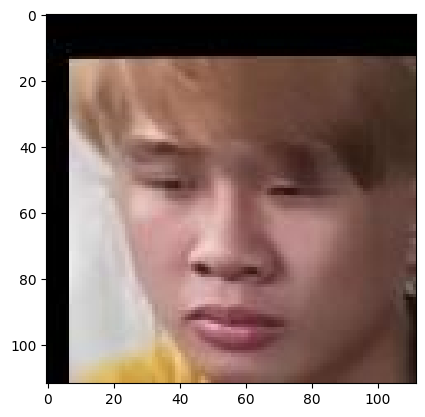

Hệ thống nhận thấy Ảnh query khớp với người có identity =  [199]
Dưới đây là các ảnh trong train dataset của người có identity =  [199]
(112, 112, 3)


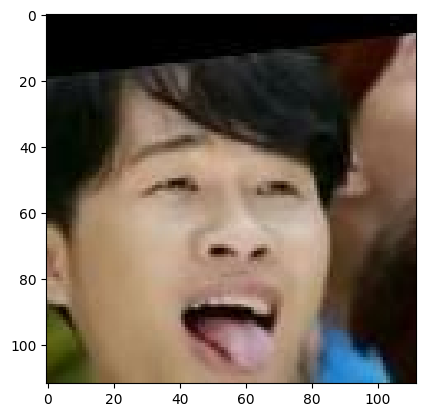

(112, 112, 3)


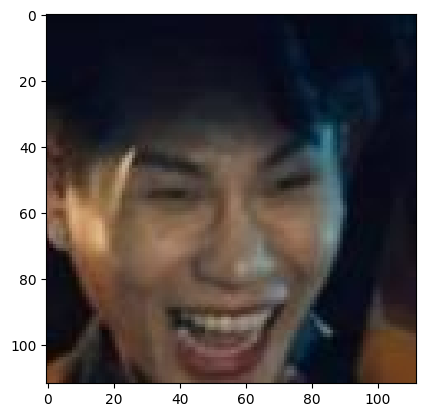

In [ ]:
check_in_image("/content/test_cases_aligned_112_112/Jay97_03.jpg", normalized_embeddings_new, imm_classes_new, filename_new)

In [ ]:
print(f"Số Identity hiện có là: {normalized_embeddings_new.shape[0]-1}")
print(f"Mỗi vector Identity có: {normalized_embeddings_new.shape[1]} giá trị")
print(f"Số lượng ảnh có trong data: {filename_new.shape[0]} picture")
print(f"Next identity:", current_identity)

Số Identity hiện có là: 199
Mỗi vector Identity có: 512 giá trị
Số lượng ảnh có trong data: 866 picture
Next identity: 200


In [ ]:
# Danh sách ảnh
imgs02 = [
    "/content/test_cases_aligned_112_112/Elon_01.jpg",
    "/content/test_cases_aligned_112_112/Elon_02.jpg"
]

# Cập nhật thông tin identity
normalized_embeddings_new, imm_classes_new, filename_new, current_identity = updater.update_identity_info(imgs02)

Số Identity hiện có là: 200
Mỗi vector Identity có: 512 giá trị
Số lượng ảnh có trong data: 868 picture
Next identity: 201


Ảnh query mà user dùng để checkin:


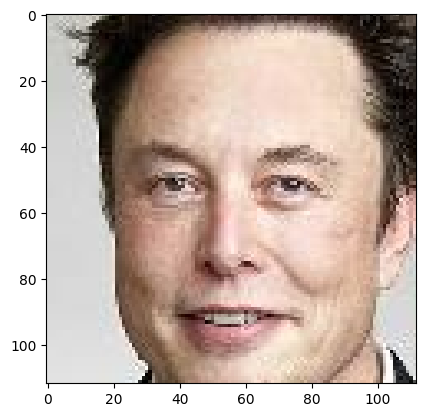

Hệ thống nhận thấy Ảnh query khớp với người có identity =  [200]
Dưới đây là các ảnh trong train dataset của người có identity =  [200]
(112, 112, 3)


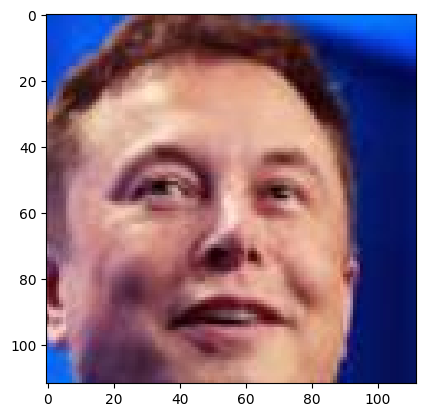

(112, 112, 3)


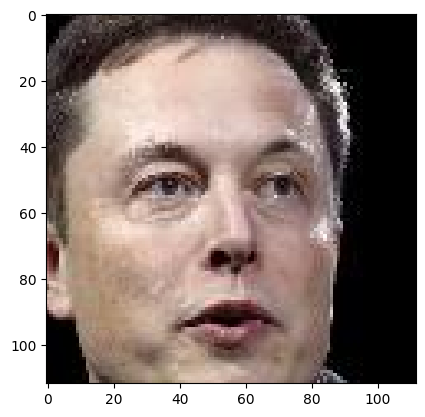

In [ ]:
check_in_image("/content/test_cases_aligned_112_112/Elon_03.jpg", normalized_embeddings_new, imm_classes_new, filename_new)

In [ ]:
# Danh sách ảnh
imgs03 = [
    "/content/test_cases_aligned_112_112/Donal_01.jpg",
    "/content/test_cases_aligned_112_112/DonaL_02.jpg"
]

# Cập nhật thông tin identity
normalized_embeddings_new, imm_classes_new, filename_new, current_identity = updater.update_identity_info(imgs03)

Số Identity hiện có là: 201
Mỗi vector Identity có: 512 giá trị
Số lượng ảnh có trong data: 870 picture
Next identity: 202


Ảnh query mà user dùng để checkin:


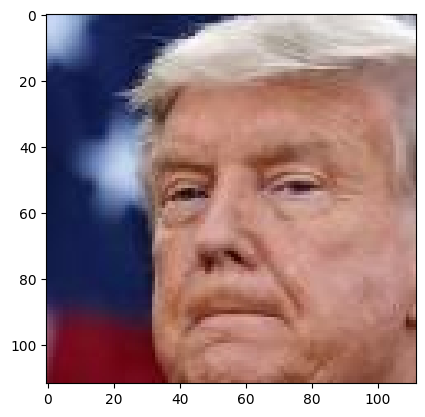

Hệ thống nhận thấy Ảnh query khớp với người có identity =  [201]
Dưới đây là các ảnh trong train dataset của người có identity =  [201]
(112, 112, 3)


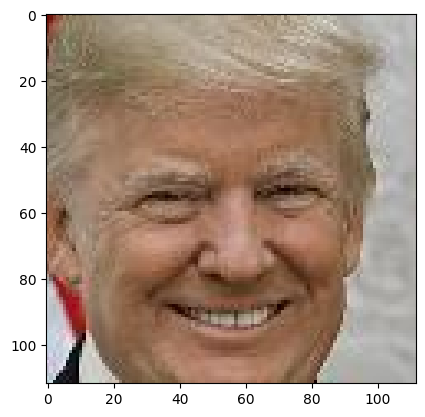

(112, 112, 3)


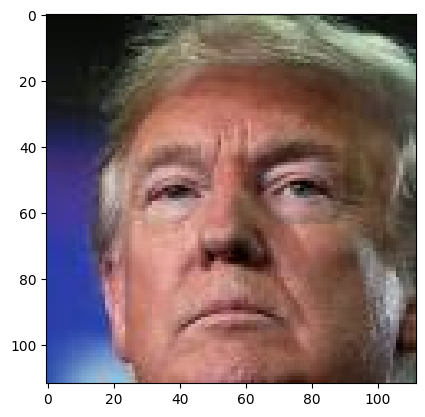

In [ ]:
check_in_image("/content/test_cases_aligned_112_112/Donal_03.jpg", normalized_embeddings_new, imm_classes_new, filename_new)